# Footstep Planning via Mixed-Integer Optimization

In [1]:
# python libraries
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display

# increase default size matplotlib figures
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

# drake imports
from pydrake.all import MathematicalProgram, OsqpSolver, eq, ge, le
from pydrake.solvers import MixedIntegerBranchAndBound

rcParams["figure.figsize"] = (10, 5)

## Problem Description

In this notebook we will implement a simplified footstep planner for a humanoid robot: we will use the method proposed [in this paper](https://groups.csail.mit.edu/robotics-center/public_papers/Deits14a.pdf).
The idea is straightforward: we need to plan where to place the feet of the robot in order to move from point A to point B.
In doing so, we are allowed to place the feet only in certain safe areas ("stepping stones") and each step cannot exceed a certain length.
To solve this problem, we will use Mixed-Integer Quadratic Programming (MIQP).

MIQP is a relatively nice class of optimization problems.
The [branch and bound algorithm](https://en.wikipedia.org/wiki/Branch_and_bound) allows to solve these problems to global optimality, whenever a solution exists, and it certifies infeasibility otherwise.
The drawback, however, is that computation times scale exponentially with the number of integer variables in the problem.

You will be asked to code most of the components of this MIQP:
- The constraint that limit the maximum step length.
- The constraint for which a foot cannot be in two stepping stones at the same time.
- The constraint that assign each foot to a stepping stone, for each step of the robot.
- The objective function that minimizes the sum of the squares of the step lengths.

Before moving on, take a look at the following videos to see the Atlas robot using this algorithm!

In [2]:
from IPython.display import IFrame, display

display(
    IFrame(
        src="https://www.youtube.com/embed/hGhCTPQuMy4",
        width="560",
        height="315",
    )
)
display(
    IFrame(
        src="https://www.youtube.com/embed/_6WQxXH-bB4",
        width="560",
        height="315",
    )
)

## Building the Terrain

We start by constructing the terrain in which the robot will walk.
For simplicity, we let the stepping stones be rectangles in the plane.

We define each stepping stone by its `center` (2d vector), its `width` (float), and its `height` (float), but we also store [its halfspace representation](https://en.wikipedia.org/wiki/Convex_polytope#Intersection_of_half-spaces).
In this representation, a stepping stone is described by a matrix $A$ and a vector $b$ such that a point $x \in \mathbb R^2$ lies inside the stepping stone iff $A x \leq b$.
Each row of the matrix $A$ represents one of the four halfspaces that delimit a 2d rectangle.
We will need these matrices later in the notebook when we will use an MIP technique known as [the big-M method](https://optimization.cbe.cornell.edu/index.php/Disjunctive_inequalities).

In [3]:
class SteppingStone(object):
    def __init__(self, center, width, height, name=None):
        # store arguments
        self.center = center
        self.width = width
        self.height = height
        self.name = name

        # distance from center to corners
        c2tr = np.array([width, height]) / 2
        c2br = np.array([width, -height]) / 2

        # position of the corners
        self.top_right = center + c2tr
        self.bottom_right = center + c2br
        self.top_left = center - c2br
        self.bottom_left = center - c2tr

        # halfspace representation of the stepping stone
        self.A = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
        self.b = np.concatenate([c2tr] * 2) + self.A.dot(center)

    def plot(self, **kwargs):
        return plot_rectangle(self.center, self.width, self.height, **kwargs)


# helper function that plots a rectangle with given center, width, and height
def plot_rectangle(center, width, height, ax=None, frame=0.1, **kwargs):
    # make black the default edgecolor
    if not "edgecolor" in kwargs:
        kwargs["edgecolor"] = "black"

    # make transparent the default facecolor
    if not "facecolor" in kwargs:
        kwargs["facecolor"] = "none"

    # get current plot axis if one is not given
    if ax is None:
        ax = plt.gca()

    # get corners
    c2c = np.array([width, height]) / 2
    bottom_left = center - c2c
    top_right = center + c2c

    # plot rectangle
    rect = Rectangle(bottom_left, width, height, **kwargs)
    ax.add_patch(rect)

    # scatter fake corners to update plot limits (bad looking but compact)
    ax.scatter(*bottom_left, s=0)
    ax.scatter(*top_right, s=0)

    # make axis scaling equal
    ax.set_aspect("equal")

    return rect

Now that we have the building block for the construction of the robot's terrain, we place the stepping stones.
The idea is to replicate the task that Atlas performs in the first video above (at time 1:24).

The following class that takes a list of boolean values (e.g. `bool_bridge = [0, 1, 1, 0, 0, 1]`) and generates a collection of stepping stones.
We have the `initial` stepping stone on the left, the `goal` stepping stone on the right, the `lateral` stepping stone at the top, and a set of `bridge` stepping stones that connect the `initial` stone to the `goal`.
With all the `bridge` stepping stones in place, there would be an easy path for the robot to reach the `goal`.
However, out of the potential `len(bool_bridge)` stepping stones forming the bridge, only the ones with entry equal to `1` are actually there.

If this description is not super clear, quickly run the next couple of cells and play with the list of booleans in the line `Terrain([1, 0, 1, 1, 0, 1]).plot()`.


In [4]:
class Terrain(object):
    # parametric construction of the stepping stones
    # the following code adapts the position of each stepping
    # stone depending on the size and the sparsity of bool_bridge
    def __init__(self, bool_bridge):
        # ensure that bool_bridge has only boolean entries
        if any(i != bool(i) for i in bool_bridge):
            raise ValueError("Entry bool_bridge must be a list of boolean value.")

        # initialize internal list of stepping stones
        self.stepping_stones = []

        # add initial stepping stone to the terrain
        initial = self.add_stone([0, 0], 1, 1, "initial")

        # add bridge stepping stones to the terrain
        # gap between bridge stones equals bridge stone width
        width_bridge = 0.2
        center = initial.bottom_right + np.array(
            [width_bridge * 1.5, initial.height / 4]
        )
        centers = [
            center + np.array([i * 2 * width_bridge, 0])
            for i in np.where(bool_bridge)[0]
        ]
        self.add_stones(
            centers,
            [width_bridge] * sum(bool_bridge),
            [initial.height / 2] * sum(bool_bridge),
            "bridge",
        )

        # add goal stepping stone to the terrain
        # same dimensions of the initial one
        center = initial.center + np.array(
            [initial.width + (len(bool_bridge) * 2 + 1) * width_bridge, 0]
        )
        goal = self.add_stone(center, initial.width, initial.height, "goal")

        # add lateral stepping stone to the terrain
        height = 0.4
        clearance = 0.1
        c2g = goal.center - initial.center
        width = initial.width + c2g[0]
        center = (
            initial.center
            + c2g / 2
            + np.array([0, (initial.height + height) / 2 + clearance])
        )
        self.add_stone(center, width, height, "lateral")

    # adds a stone to the internal list stepping_stones
    def add_stone(self, center, width, height, name=None):
        stone = SteppingStone(center, width, height, name=name)
        self.stepping_stones.append(stone)
        return stone

    # adds multiple stones to the internal list stepping_stones
    def add_stones(self, centers, widths, heights, name=None):
        # ensure that inputs have coherent size
        n_stones = len(centers)
        if n_stones != len(widths) or n_stones != len(heights):
            raise ValueError("Arguments have incoherent size.")

        # add one stone per time
        stones = []
        for i in range(n_stones):
            stone_name = name if name is None else name + "_" + str(i)
            stones.append(
                self.add_stone(centers[i], widths[i], heights[i], name=stone_name)
            )

        return stones

    # returns the stone with the given name
    # raise a ValueError if no stone has the given name
    def get_stone_by_name(self, name):
        # loop through the stones
        # select the first with the given name
        for stone in self.stepping_stones:
            if stone.name == name:
                return stone

        # raise error if there is no stone with the given name
        raise ValueError(f"No stone in the terrain has name {name}.")

    # plots all the stones in the terrain
    def plot(self, title=None, **kwargs):
        # make light green the default facecolor
        if not "facecolor" in kwargs:
            kwargs["facecolor"] = [0, 1, 0, 0.1]

        # plot stepping stones disposition
        labels = ["Stepping stone", None]
        for i, stone in enumerate(self.stepping_stones):
            stone.plot(label=labels[min(i, 1)], **kwargs)

        # set title
        plt.title(title)

Use the next cell to play with the list of booleans and make the stones in the bridge appear and disappear.
You can also modify the length of the list and the position of the stepping stones will adapt automatically.

At the end of the notebook, we will focus on two specific setups: `bool_bridge = [1, 1, 1, 1]` and `bool_bridge = [1, 1, 1, 0]`.
In the first case, we expect the robot to walk straight through the bridge to arrive at the goal.
In the second, given the strict limits we will enforce on the maximum step length, the robot will have to use the lateral stepping stone.

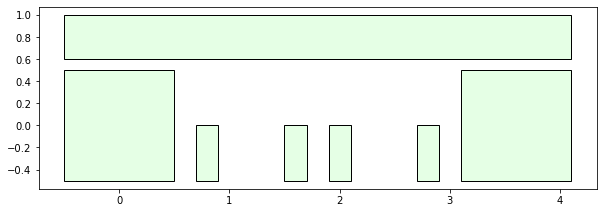

In [5]:
Terrain([1, 0, 1, 1, 0, 1]).plot()

## The Mixed-Integer Optimization Problem

It's time to write the core of the footstep planner: the MIQP.
We start by defining the decision variables.
We do this inside of a function, since we ultimately want to define a `footstep_planner` function that given a `terrain` (and a couple of additional parameters) returns the optimal plan to walk through it.

Here is the meaning of the variables in the following function:
- `n_steps` is the maximum number of steps that the robot can take to reach the goal.
- The 2d array `position_left[t]` contains the Cartesian coordinates of the left foot at step `t`.
Similarly for `position_right[t]`.
- If the binary variable `stone_left[t, i]` is one then, at step `t`, the left foot must be placed on stone `i`.
Since a foot cannot be in two stepping stones at the same time, below we will also add the constraint `sum(stone_left[t]) == 1`.
Similarly for `stone_right[t, i]`.
- The binary `first_left` is one if the first step is taken with the left foot, zero if it is taken with the right foot.

In [6]:
def add_decision_variables(prog, terrain, n_steps):
    # number of stones in the terrain
    n_stones = len(terrain.stepping_stones)

    # position of each foot at each step
    position_left = prog.NewContinuousVariables(rows=n_steps + 1, cols=2)
    position_right = prog.NewContinuousVariables(rows=n_steps + 1, cols=2)

    # binaries that assign feet to stones for each step
    stone_left = prog.NewBinaryVariables(rows=n_steps + 1, cols=n_stones)
    stone_right = prog.NewBinaryVariables(rows=n_steps + 1, cols=n_stones)

    # which foot to move first
    first_left = prog.NewBinaryVariables(1)[0]

    return position_left, position_right, stone_left, stone_right, first_left

We let the initial position of the feet be close to the center of the `initial` stepping stone.
The same for the goal.
Then we require that the first and last entries in the `position_left` and `position_right` variables defined above agree with these values.

In [7]:
def set_initial_and_goal_position(prog, terrain, decision_variables):
    # unpack only decision variables needed in this function
    position_left, position_right = decision_variables[:2]

    # initial position of the feet of the robot
    foot_offset = np.array([0, 0.2])
    center = terrain.get_stone_by_name("initial").center
    initial_position_left = center
    initial_position_right = center - foot_offset

    # goal position of the feet of the robot
    center = terrain.get_stone_by_name("goal").center
    goal_position_left = center
    goal_position_right = center - foot_offset

    # enforce initial position of the feet
    prog.AddLinearConstraint(eq(position_left[0], initial_position_left))
    prog.AddLinearConstraint(eq(position_right[0], initial_position_right))

    # enforce goal position of the feet
    prog.AddLinearConstraint(eq(position_left[-1], goal_position_left))
    prog.AddLinearConstraint(eq(position_right[-1], goal_position_right))

Since the robot has kinematic limits, its steps cannot be too long.
More specifically, at each step `t` from `0` to `n_steps`, we want each foot to lie in a square centered at the other foot.
The float `step_span` represents the side of this square (the whole side, not half of it).

Your turn to code: in the following cell complete the function `relative_position_limits` to enforce the constraint we just described.
So far we have only unpacked the decision variables you need to constrain.

P.s.: You might need the constructor `prog.AddLinearConstraint(le(x, y))` to enforce the constraint that the array `x` must be `l`ower than or `e`qual to the array `y`.
`ge` can be used similarly.

In [12]:
prog = MathematicalProgram()
variable = prog.NewContinuousVariables(rows=3, cols=2)
print(f"variable shape: {variable.shape}")
for ith_step in variable:
    print(ith_step)

variable shape: (3, 2)
[Variable('x(0,0)', Continuous) Variable('x(0,1)', Continuous)]
[Variable('x(1,0)', Continuous) Variable('x(1,1)', Continuous)]
[Variable('x(2,0)', Continuous) Variable('x(2,1)', Continuous)]


In [13]:
def relative_position_limits(prog, n_steps, step_span, decision_variables):
    # unpack only decision variables needed in this function
    position_left, position_right = decision_variables[:2]

    # modify here
    for ith_left, ith_right in zip(position_left, position_right):
        prog.AddLinearConstraint(le(abs(ith_left-ith_right), step_span/2.))

The following constraint is somewhat involved to implement, but the idea behind it is straightforward.
If we take the first step with, e.g., the left foot (`first_left == 1`), then we implicitly associated each step in the plan to a foot; using zero-based indexing: 0th step left, 1st step right, 2nd step left, 3rd step right, etc.
The following function ensures that, if we move the left foot first, then the left foot will not move during an "odd" step and the right foot will not move during an "even" step.
Similarly if we decide to take the first step with the right foot.

Here is how we implemented it.
At each step `t`, we require the next position of a foot to lie in a square centered at its current position.
We then use the binaries `first_left` and `first_right = 1 - first_left` to make the side of this square sufficiently large or zero, depending on whether the foot is allowed to move at step `t`.
Take a couple of minutes to double check that we got the implementation right!

In [ ]:
def step_sequence(prog, n_steps, step_span, decision_variables):
    # unpack only decision variables needed in this function
    position_left, position_right = decision_variables[:2]
    first_left = decision_variables[-1]

    # variable equal to one if first step is with right foot
    first_right = 1 - first_left

    # note that the step_span coincides with the maximum distance
    # (both horizontal and vertical) between the position of
    # a foot at step t and at step t + 1
    step_limit = np.ones(2) * step_span

    # sequence for the robot steps implied by the binaries first_left and first_right
    # (could be written more compactly, but would be harder to read)
    for t in range(n_steps):
        # lengths of the steps
        step_left = position_left[t + 1] - position_left[t]
        step_right = position_right[t + 1] - position_right[t]

        # for all even steps
        if t % 2 == 0:
            limit_left = step_limit * first_left  # left foot can move iff first_left
            limit_right = (
                step_limit * first_right
            )  # right foot can move iff first_right

        # for all odd steps
        else:
            limit_left = step_limit * first_right  # left foot can move iff first_right
            limit_right = step_limit * first_left  # right foot can move iff first_left

        # constraints on left-foot relative position
        prog.AddLinearConstraint(le(step_left, limit_left))
        prog.AddLinearConstraint(ge(step_left, -limit_left))

        # constraints on right-foot relative position
        prog.AddLinearConstraint(le(step_right, limit_right))
        prog.AddLinearConstraint(ge(step_right, -limit_right))

Now it's your turn to code again.
As mentioned before, a foot cannot be in two stepping stones at the same time.
This can be enforced by requiring that, for each step `t`, the binaries `stone_left[t]` sum up to one.
The same for `stone_right[t]`.
Implement this linear constraint in the following function.

In [ ]:
def one_stone_per_foot(prog, n_steps, decision_variables):
    # unpack only decision variables needed in this function
    stone_left, stone_right = decision_variables[2:4]

    # modify here

One more constraint to add: "if the binary `stone_left[t, i]` is one, then the left foot at step `t` must lie on the `i`th stepping stone".
To enforce this constraint we use the [the big-M method](https://optimization.cbe.cornell.edu/index.php/Disjunctive_inequalities).

Think of each stepping stone $S_i$ as a subset of $\mathbb R^2$.
Using the halfspace representation,
$$
S_i = \{ x \in \mathbb R^2 : A_i x \leq b_i \}.
$$
Let $x_t$ be the position of, e.g., the left foot at step $t$.
The constraint $x_t \in \bigcup_i S_i$ can be enforced as follows.
We define a binary $\delta_{t, i} \in \{0, 1\}$ per stepping stone (these are the binaries `stone_left[t, i]` we defined above).
We add the constraint
$$
A_i x_t \leq b_i + (1 - \delta_{t, i}) M_i
$$
for all $t$ and $i$, where $M_i$ is a vector of "sufficiently large" positive constants.
Additionally, as we already did in the last cell, we require
$$
\sum_i \delta_{t, i} = 1
$$
for all $t$.

Do you see how these two constraints do the job?
If $\delta_{t, i} = 1$, from the last equation, we must have $\delta_{t, j} = 0$ for all $j \neq i$.
This implies
$$
A_i x_t \leq b_i, \quad
A_j x_t \leq b_j + M_j.
$$
Therefore $x_t$ belongs to $S_i$, while, since $M_j$ is a vector of large constants, the second inequality is redundant and does not constrain the value of $x_t$.

It's very important to notice that these constraints are linear in our decision variables ($x_t$ and $\delta_{t, i}$).
Mixed-integer programs with nonlinear constraints are extremely hard problems, especially if some of the constraints are nonconvex.

One issue left: what's the magic value for the constants $M_i$?
One would be tempted to put a huge number there, but unfortunately the larger the $M_i$ the harder the problem is to be solved via branch and bound.
In the following cell we wrote a function that returns a vector $M$ that can be used for all $i$.
(This is possible since our stepping stones are rectangles and they all have the same number of facets, 4, which is equal to the number of rows in $A_i$).
If you are not a MIP enthusiast, do not feel the need to understand the logic behind the following function.

In [ ]:
# parameter for the big-M method
# carefully chosen for the terrain above


def get_big_M(terrain):
    # big-M parameter for the horizontal axis
    initial = terrain.get_stone_by_name("initial")
    goal = terrain.get_stone_by_name("goal")
    M = [goal.center[0] - initial.center[0]]

    # big-M parameter for the vertical axis
    lateral = terrain.get_stone_by_name("lateral")
    M.append(lateral.top_right[1] - initial.center[1])

    return np.array(M * 2)

In the following cell, for each step $t$ and stone $i$, implement the big-M constraint
$$
A_i x_t \leq b_i + (1 - \delta_{t, i}) M,
$$
where $x_t$ represents the variable `position_left[t]` (respectively `position_right[t]`), $\delta_{t, i}$ is `stone_left[t, i]` (respectively `stone_right[t, i]`), and $M$ is obtained via the function `get_big_M` we just defined.
The arrays $A_i$ and $b_i$ are stored as attributes of the class `SteppingStone`.
Stones are assumed to be ordered as in the list `terrain.stepping_stones`, meaning that the $i$th stone here is `terrain.stepping_stones[i]`.

In [ ]:
def foot_in_stepping_stone(prog, terrain, n_steps, decision_variables):
    # unpack only decision variables needed in this function
    (
        position_left,
        position_right,
        stone_left,
        stone_right,
    ) = decision_variables[:4]

    # big-M vector
    M = get_big_M(terrain)

    # modify here

The last piece of code you are asked to write.
In order to promote small steps, add a quadratic objective that minimizes the step length.
More precisely, for each step `t`, add to the cost function the square of the two norm of `position_left[t + 1] - position_left[t]` and the square of the two norm of `position_right[t + 1] - position_right[t]`.
To do this, you can use the `MathematicalProgram` method `AddQuadraticCost`.

For the moment we added a dummy objective function.
This is just needed to let the notebook run without errors: erase it to write your own.

In [ ]:
def minimize_step_length(prog, n_steps, decision_variables):
    # unpack only decision variables needed in this function
    position_left, position_right = decision_variables[:2]

    # dummy objective needed to let the notebook run without errors # erase here
    prog.AddQuadraticCost(
        position_left.flatten().dot(position_left.flatten())
    )  # erase here
    prog.AddQuadraticCost(
        position_right.flatten().dot(position_right.flatten())
    )  # erase here

    # modify here

The footstep planner is ready!
In the following cell we just put together all the pieces we wrote so far and solve the optimization.

In [ ]:
def footstep_planner(terrain, n_steps, step_span):
    # initialize optimization problem
    prog = MathematicalProgram()

    # optimization variables
    decision_variables = add_decision_variables(prog, terrain, n_steps)

    # constraints
    set_initial_and_goal_position(prog, terrain, decision_variables)
    relative_position_limits(prog, n_steps, step_span, decision_variables)
    step_sequence(prog, n_steps, step_span, decision_variables)
    one_stone_per_foot(prog, n_steps, decision_variables)
    foot_in_stepping_stone(prog, terrain, n_steps, decision_variables)

    # objective function
    minimize_step_length(prog, n_steps, decision_variables)

    # solve
    bb = MixedIntegerBranchAndBound(prog, OsqpSolver().solver_id())
    result = bb.Solve()

    # ensure that the problem is feasible
    if result != result.kSolutionFound:
        raise ValueError("Infeasible optimization problem.")

    # retrieve result of the optimization
    decision_variables_opt = [bb.GetSolution(v) for v in decision_variables]
    objective_opt = bb.GetOptimalCost()

    return decision_variables_opt, objective_opt

## Try the Footstep Planner on two Terrains

We consider the following two terrains.

In [ ]:
# complete bridge
terrain_A = Terrain([1, 1, 1, 1])
terrain_A.plot("Terrain A")
plt.show()

# one stepping stone missing in the bridge
terrain_B = Terrain([1, 1, 1, 0])
terrain_B.plot("Terrain B")
plt.show()

These are the additional parameters for the footstep planner.
`n_steps` is chosen to make the optimizations solvable in a few seconds, `step_span` to achieve a specific behaviour you'll see in a couple of cells.

In [ ]:
# maximum number of steps to reach the goal
n_steps = 8

# side of the square that limits each step
step_span = 0.8

Here is an animation function that you can use to check your result.

In [ ]:
def animate_footstep_plan(
    terrain, step_span, position_left, position_right, title=None
):
    # initialize figure for animation
    fig, ax = plt.subplots()

    # plot stepping stones
    terrain.plot(title=title, ax=ax)

    # initial position of the feet
    left_foot = ax.scatter(0, 0, color="r", zorder=3, label="Left foot")
    right_foot = ax.scatter(0, 0, color="b", zorder=3, label="Right foot")

    # initial step limits
    left_limits = plot_rectangle(
        [0, 0],  # center
        step_span,  # width
        step_span,  # eight
        ax=ax,
        edgecolor="b",
        label="Left-foot limits",
    )
    right_limits = plot_rectangle(
        [0, 0],  # center
        step_span,  # width
        step_span,  # eight
        ax=ax,
        edgecolor="r",
        label="Right-foot limits",
    )

    # misc settings
    plt.close()
    ax.legend(loc="upper left", bbox_to_anchor=(0, 1.3), ncol=2)

    def animate(n_steps):
        # scatter feet
        left_foot.set_offsets(position_left[n_steps])
        right_foot.set_offsets(position_right[n_steps])

        # limits of reachable set for each foot
        c2c = np.ones(2) * step_span / 2
        right_limits.set_xy(position_left[n_steps] - c2c)
        left_limits.set_xy(position_right[n_steps] - c2c)

    # create ad display animation
    ani = FuncAnimation(fig, animate, frames=n_steps + 1, interval=1e3)
    display(HTML(ani.to_jshtml()))


def generate_and_animate_footstep_plan(terrain, n_steps, step_span, title=None):
    # run footstep planner
    decision_variables, objective = footstep_planner(terrain, n_steps, step_span)

    # animate result
    animate_footstep_plan(terrain, step_span, *decision_variables[:2], title)

Here is the animation of the footstep planner for the two benchmark terrains.
If you did things correctly, you should see the robot crossing the bridge for `terrain_A`.
Whereas the max step limit requires it to take the less efficient route at the top of the terrain (`lateral` stone) in case of `terrain_B`.
Note that a local solver (as opposed to branch and bound which is a global optimizer) would have had a very hard time realizing this!

In [ ]:
generate_and_animate_footstep_plan(terrain_A, n_steps, step_span, "Terrain A")
generate_and_animate_footstep_plan(terrain_B, n_steps, step_span, "Terrain B")

## Final Comments

In this notebook we used a "simple" branch-and-bound solver (written in Drake by Hongkai Dai).
If you want to solve this problem for larger terrains, you might need something more advanced.
Drake supports two state-of-the-art solvers for mixed-integer programming (both free for academic use): [Gurobi](https://www.gurobi.com) and [Mosek](https://www.mosek.com).
With these, you should be able to approximately double the stepping stones in these terrains and the maximum number of steps.

Here we used the big-M method, which is the simplest way in which we can transcribe the the footstep planning problem into an MIQP.
Much more efficient transcription techniques are available.
If you are interested, have a look at [this very nice survey paper](https://dspace.mit.edu/bitstream/handle/1721.1/96480/Vielma-2015-Mixed%20Integer%20Linear.pdf?sequence=1&isAllowed=y).

## Autograding

You can check your work by running the following cell.

In [ ]:
from underactuated.exercises.grader import Grader
from underactuated.exercises.humanoids.test_footstep_planning import (
    TestFootstepPlanning,
)

Grader.grade_output([TestFootstepPlanning], [locals()], "results.json")
Grader.print_test_results("results.json")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a0b741c1-31ed-480b-992f-b4307d227e58' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>